# Model Selection

## Mục tiêu

- So sánh hiệu suất tất cả các mô hình trên tập validation
- Xác định mô hình tốt nhất dựa trên MAE score
- Dự đoán tuổi thọ trên tập test sử dụng mô hình tốt nhất
- Phân tích kết quả dự đoán trên test set, bao gồm:
  - Kết quả dự đoán chi tiết cho từng quốc gia
  - So sánh validation vs test performance (phát hiện overfitting)
  - Phân tích lỗi theo các nhóm tuổi thọ
  - Vẽ biểu đồ insights

## Giới thiệu

Phần này so sánh toàn bộ các mô hình đã huấn luyện và chọn ra mô hình tốt nhất dựa trên:

1. **MAE (Mean Absolute Error)**: Metric chính - ổn định với outliers, dễ diễn giải
2. **RMSE (Root Mean Squared Error)**: Phạt lỗi lớn hơn, giúp phát hiện dự đoán sai lệch
3. **R² Score**: Độ phù hợp - tỷ lệ phương sai được giải thích

Sau khi chọn mô hình tốt nhất, ta sẽ dùng nó để dự đoán tuổi thọ trên tập test và phân tích chi tiết kết quả.

## Bước 1 - Import các thư viện cần thiết

In [12]:
import os
import joblib
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set style cho biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Bước 2 - Đọc dữ liệu validation và test

In [13]:
# Đọc dữ liệu
val_df = pd.read_csv('../data/processed/val.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print("THÔNG TIN DỮ LIỆU VALIDATION VÀ TEST")
print("="*60)
print(f"Kích thước tập validation: {val_df.shape}")
print(f"Kích thước tập test: {test_df.shape}")

# Định nghĩa các cột dùng để dự đoán
feature_cols = [col for col in val_df.columns
                if col not in ['life_expectancy', 'country_name', 'country_code']]

# Tách X và y cho tập validation
X_val = val_df[feature_cols]
y_val = val_df['life_expectancy']

# Tách X và y cho tập test
X_test = test_df[feature_cols]
y_test = test_df['life_expectancy']

print(f"\nSố lượng đặc trưng: {len(feature_cols)}")

THÔNG TIN DỮ LIỆU VALIDATION VÀ TEST
Kích thước tập validation: (1085, 15)
Kích thước tập test: (1085, 15)

Số lượng đặc trưng: 12


## Bước 3 - Load tất cả các mô hình

In [14]:
BASE_DIR = Path('../model')

# Dictionary lưu các mô hình
models = {}

# ===== 1. Linear Models =====
models['Linear'] = joblib.load(BASE_DIR / "1_linear_regression" / "linear.pkl")
models['Ridge'] = joblib.load(BASE_DIR / "1_linear_regression" / "ridge.pkl")
models['Lasso'] = joblib.load(BASE_DIR / "1_linear_regression" / "lasso.pkl")

# ===== 2. SVM =====
models['LinearSVR'] = joblib.load(BASE_DIR / "2_SVM_regression" / "linear_svr.pkl")
models['SVR_RBF'] = joblib.load(BASE_DIR / "2_SVM_regression" / "svr_rbf.pkl")

# ===== 3. Decision Tree =====
models['DecisionTree'] = joblib.load(BASE_DIR / "3_decision_tree" / "decision_tree.pkl")

# ===== 4. Random Forest =====
models['RandomForest'] = joblib.load(BASE_DIR / "4_random_forest" / "random_forest.pkl.gz")

# ===== 5. GBM =====
models['GBM'] = joblib.load(BASE_DIR / "5_GBM" / "GBM.pkl.gz")

# ===== 6. LightGBM =====
models['LightGBM'] = joblib.load(BASE_DIR / "6_lightgbm" / "lightgbm.pkl")

# ===== 7. XGBoost =====
models['XGBoost'] = joblib.load(BASE_DIR / "7_xgboost" / "xgboost.pkl.gz")

# ===== 8. CatBoost =====
models['CatBoost'] = joblib.load(BASE_DIR / "8_catboost" / "catboost.pkl.gz")

# ===== 9. Voting Ensemble =====
voting_ensemble_data = joblib.load(BASE_DIR / "9_voting_ensemble" / "voting_ensemble.pkl.gz")
models['Voting_Ensemble'] = voting_ensemble_data['base_models']

print("TẤT CẢ CÁC MÔ HÌNH ĐÃ ĐƯỢC LOAD")
print("="*60)
print(f"Số lượng mô hình: {len(models)}")
for i, model_name in enumerate(models.keys(), 1):
    print(f"{i:2d}. {model_name}")

TẤT CẢ CÁC MÔ HÌNH ĐÃ ĐƯỢC LOAD
Số lượng mô hình: 12
 1. Linear
 2. Ridge
 3. Lasso
 4. LinearSVR
 5. SVR_RBF
 6. DecisionTree
 7. RandomForest
 8. GBM
 9. LightGBM
10. XGBoost
11. CatBoost
12. Voting_Ensemble


## Bước 4 - Đánh giá tất cả các mô hình trên tập validation

In [18]:
# Đánh giá từng mô hình
val_results = {}

print("ĐÁNH GIÁ VALIDATION")
print("="*90)
print(f"{'Model':<20} | {'MAE':<10} | {'RMSE':<10} | {'R²':<10}")
print("-"*90)

for model_name, model in models.items():
    if model_name != 'Voting_Ensemble':
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        val_results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"{model_name:<20} | {mae:<10.4f} | {rmse:<10.4f} | {r2:<10.4f}")

# Thêm Voting Ensemble
base_models = voting_ensemble_data['base_models']
weights = voting_ensemble_data['weights']

y_val_voting = np.zeros(len(y_val))
for model_name, weight in weights.items():
    model = base_models[model_name]
    y_pred_model = model.predict(X_val)
    y_val_voting += weight * y_pred_model

mae_voting = mean_absolute_error(y_val, y_val_voting)
rmse_voting = np.sqrt(mean_squared_error(y_val, y_val_voting))
r2_voting = r2_score(y_val, y_val_voting)

val_results['Voting_Ensemble'] = {'MAE': mae_voting, 'RMSE': rmse_voting, 'R2': r2_voting}

print(f"{'Voting_Ensemble':<20} | {mae_voting:<10.4f} | {rmse_voting:<10.4f} | {r2_voting:<10.4f}")
print("="*90)


ĐÁNH GIÁ VALIDATION
Model                | MAE        | RMSE       | R²        
------------------------------------------------------------------------------------------
Linear               | 3.0885     | 4.0341     | 0.7734    
Ridge                | 3.0890     | 4.0331     | 0.7735    
Lasso                | 3.0873     | 4.0311     | 0.7738    
LinearSVR            | 3.0530     | 4.1461     | 0.7607    
SVR_RBF              | 1.9097     | 2.7625     | 0.8938    
DecisionTree         | 1.8219     | 2.5494     | 0.9095    
SVR_RBF              | 1.9097     | 2.7625     | 0.8938    
DecisionTree         | 1.8219     | 2.5494     | 0.9095    
RandomForest         | 0.8619     | 1.3083     | 0.9762    
GBM                  | 0.9176     | 1.4199     | 0.9719    
LightGBM             | 0.8936     | 1.2948     | 0.9767    
XGBoost              | 0.8208     | 1.2152     | 0.9794    
CatBoost             | 0.7751     | 1.1594     | 0.9813    
RandomForest         | 0.8619     | 1.3083     | 

## Bước 5 - Xác định mô hình tốt nhất

Lý giải lý do

In [26]:
# Tạo DataFrame từ kết quả validation
val_df_results = pd.DataFrame(val_results).T.reset_index()
val_df_results.columns = ['Model', 'MAE', 'RMSE', 'R2']
val_df_results = val_df_results.sort_values('MAE').reset_index(drop=True)

print("\nBÁNG XẾP HẠNG MÔ HÌNH (Sắp xếp theo MAE)")
print("="*90)
display(val_df_results)

# Xác định mô hình tốt nhất
best_model_name = val_df_results.iloc[0]['Model']
best_mae = val_df_results.iloc[0]['MAE']
best_rmse = val_df_results.iloc[0]['RMSE']
best_r2 = val_df_results.iloc[0]['R2']

print("\n" + "="*90)
print(f"MÔ HÌNH TỐT NHẤT: {best_model_name}")
print("-"*90)
print(f"MAE  : {best_mae:.4f}")
print(f"RMSE : {best_rmse:.4f}")
print(f"R²   : {best_r2:.4f}")


BÁNG XẾP HẠNG MÔ HÌNH (Sắp xếp theo MAE)


,Model,MAE,RMSE,R2
0,CatBoost,0.775147,1.159356,0.981287
1,XGBoost,0.820808,1.215179,0.979441
2,Voting_Ensemble,0.855825,1.231878,0.978872
3,RandomForest,0.861892,1.308259,0.976171
4,LightGBM,0.893616,1.294753,0.976661
5,GBM,0.917628,1.419855,0.971932
6,DecisionTree,1.821872,2.549390,0.909512
7,SVR_RBF,1.909660,2.762514,0.893751
8,LinearSVR,3.053039,4.146135,0.760666
9,Lasso,3.087293,4.031067,0.773766



MÔ HÌNH TỐT NHẤT: CatBoost
------------------------------------------------------------------------------------------
MAE  : 0.7751
RMSE : 1.1594
R²   : 0.9813


Mô hình tốt nhất tìm được là CatBoost Regressor. Xét trên tập validation, CatBoost cho kết quả tốt hơn hẳn các mô hình còn lại dựa trên cả 3 metrics: MAE, RMSE, R2.

## Bước 6 - Dự đoán trên tập test sử dụng mô hình tốt nhất

### 6.1. Đánh giá mô hình trên tập test sử dụng 3 metrics: MAE, RMSE và R2

In [32]:
# Load mô hình tốt nhất
if best_model_name == 'Voting_Ensemble':
    y_test_pred = np.zeros(len(y_test))
    for model_name, weight in weights.items():
        model = base_models[model_name]
        y_pred_model = model.predict(X_test)
        y_test_pred += weight * y_pred_model
else:
    best_model = models[best_model_name]
    y_test_pred = best_model.predict(X_test)

# Tính metrics trên test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\nKẾT QUẢ DỰ ĐOÁN TRÊN TẬP TEST")
print("="*90)
print(f"Mô hình: {best_model_name}")
print("-"*90)
print(f"MAE  : {test_mae:7.4f}")
print(f"RMSE : {test_rmse:7.4f}")
print(f"R²   : {test_r2:7.4f}")


KẾT QUẢ DỰ ĐOÁN TRÊN TẬP TEST
Mô hình: CatBoost
------------------------------------------------------------------------------------------
MAE  :  0.8021
RMSE :  1.3301
R²   :  0.9761


### 6.2. Kết quả dự đoán chi tiết trên test set

In [40]:
# Tạo DataFrame kết quả dự đoán
test_results_df = pd.DataFrame({
    'Quốc gia': test_df['country_name'],
    'Tuổi thọ thực': y_test.values,
    'Tuổi thọ dự đoán': y_test_pred,
    'Chênh lệch': np.abs(y_test.values - y_test_pred),
    'Chênh lệch %': (np.abs(y_test.values - y_test_pred) / y_test.values) * 100
})

# Sắp xếp theo lỗi giảm dần
test_results_df = test_results_df.sort_values('Chênh lệch', ascending=False).reset_index(drop=True)

print("\nKẾT QUẢ DỰ ĐOÁN CHI TIẾT (Sắp xếp theo chênh lệch tuổi lớn nhất)")
print("="*100)
display(test_results_df.round(4))

# Thống kê lỗi
print("\n" + "="*100)
print("THỐNG KÊ LỖI DỰ ĐOÁN")
print("="*100)
print(f"Chênh lệch trung bình (MAE)     : {test_results_df['Chênh lệch'].mean():.4f} năm")
print(f"Chênh lệch trung bình (%)       : {test_results_df['Chênh lệch %'].mean():.4f}%")
print(f"Chênh lệch cao nhất             : {test_results_df['Chênh lệch'].max():.4f} năm ({test_results_df['Chênh lệch %'].max():.4f}%)")
print(f"Chênh lệch thấp nhất            : {test_results_df['Chênh lệch'].min():.4f} năm ({test_results_df['Chênh lệch %'].min():.4f}%)")
print(f"Độ lệch chuẩn (std)             : {test_results_df['Chênh lệch'].std():.4f} năm")


KẾT QUẢ DỰ ĐOÁN CHI TIẾT (Sắp xếp theo chênh lệch tuổi lớn nhất)


,Quốc gia,Tuổi thọ thực,Tuổi thọ dự đoán,Chênh lệch,Chênh lệch %
0,Central African Republic,31.530,47.7632,16.2332,51.4850
1,Haiti,45.577,58.5560,12.9790,28.4771
2,West Bank and Gaza,65.170,75.1992,10.0292,15.3892
3,Liberia,53.045,59.9890,6.9440,13.0908
4,Central African Republic,40.265,34.1429,6.1221,15.2045
...,...,...,...,...,...
1080,Kazakhstan,73.503,73.5057,0.0027,0.0036
1081,Belgium,78.878,78.8806,0.0026,0.0032
1082,French Polynesia,79.000,78.9988,0.0012,0.0015
1083,Uzbekistan,67.905,67.9046,0.0004,0.0006



THỐNG KÊ LỖI DỰ ĐOÁN
Chênh lệch trung bình (MAE)     : 0.8021 năm
Chênh lệch trung bình (%)       : 1.2268%
Chênh lệch cao nhất             : 16.2332 năm (51.4850%)
Chênh lệch thấp nhất            : 0.0003 năm (0.0004%)
Độ lệch chuẩn (std)             : 1.0616 năm


## Bước 7 - So sánh Validation vs Test

In [47]:
# Tạo bảng so sánh
comparison_df = pd.DataFrame({
    'Metrics': ['MAE', 'RMSE', 'R²'],
    'Validation': [best_mae, best_rmse, best_r2],
    'Test': [test_mae, test_rmse, test_r2],
    'Difference': [abs(test_mae - best_mae), abs(test_rmse - best_rmse), abs(test_r2 - best_r2)]
})

print("\nSO SÁNH VALIDATION VS TEST")
print("-"*90)
display(comparison_df)

# Phân tích overfitting
mae_diff = test_mae - best_mae
rmse_diff = test_rmse - best_rmse
r2_diff = best_r2 - test_r2

print("="*90)
print("PHÂN TÍCH OVERFITTING/UNDERFITTING")
print("-"*90)

if mae_diff > 0.5:
    print("Dấu hiệu OVERFITTING: Test MAE cao hơn Validation")
elif mae_diff < -0.5:
    print("Model GENERALIZE TỐT: Test MAE tốt hơn Validation")
else:
    print("Model ỔN ĐỊNH: Validation và Test performance gần tương đương")


SO SÁNH VALIDATION VS TEST
------------------------------------------------------------------------------------------


,Metrics,Validation,Test,Difference
0,MAE,0.775147,0.802103,0.026955
1,RMSE,1.159356,1.330130,0.170774
2,R²,0.981287,0.976056,0.005231


PHÂN TÍCH OVERFITTING/UNDERFITTING
------------------------------------------------------------------------------------------
Model ỔN ĐỊNH: Validation và Test performance gần tương đương


## Bước 8 - Vẽ biểu đồ phân tích

✓ Biểu đồ đã được lưu tại: ../outputs/model_selection.png


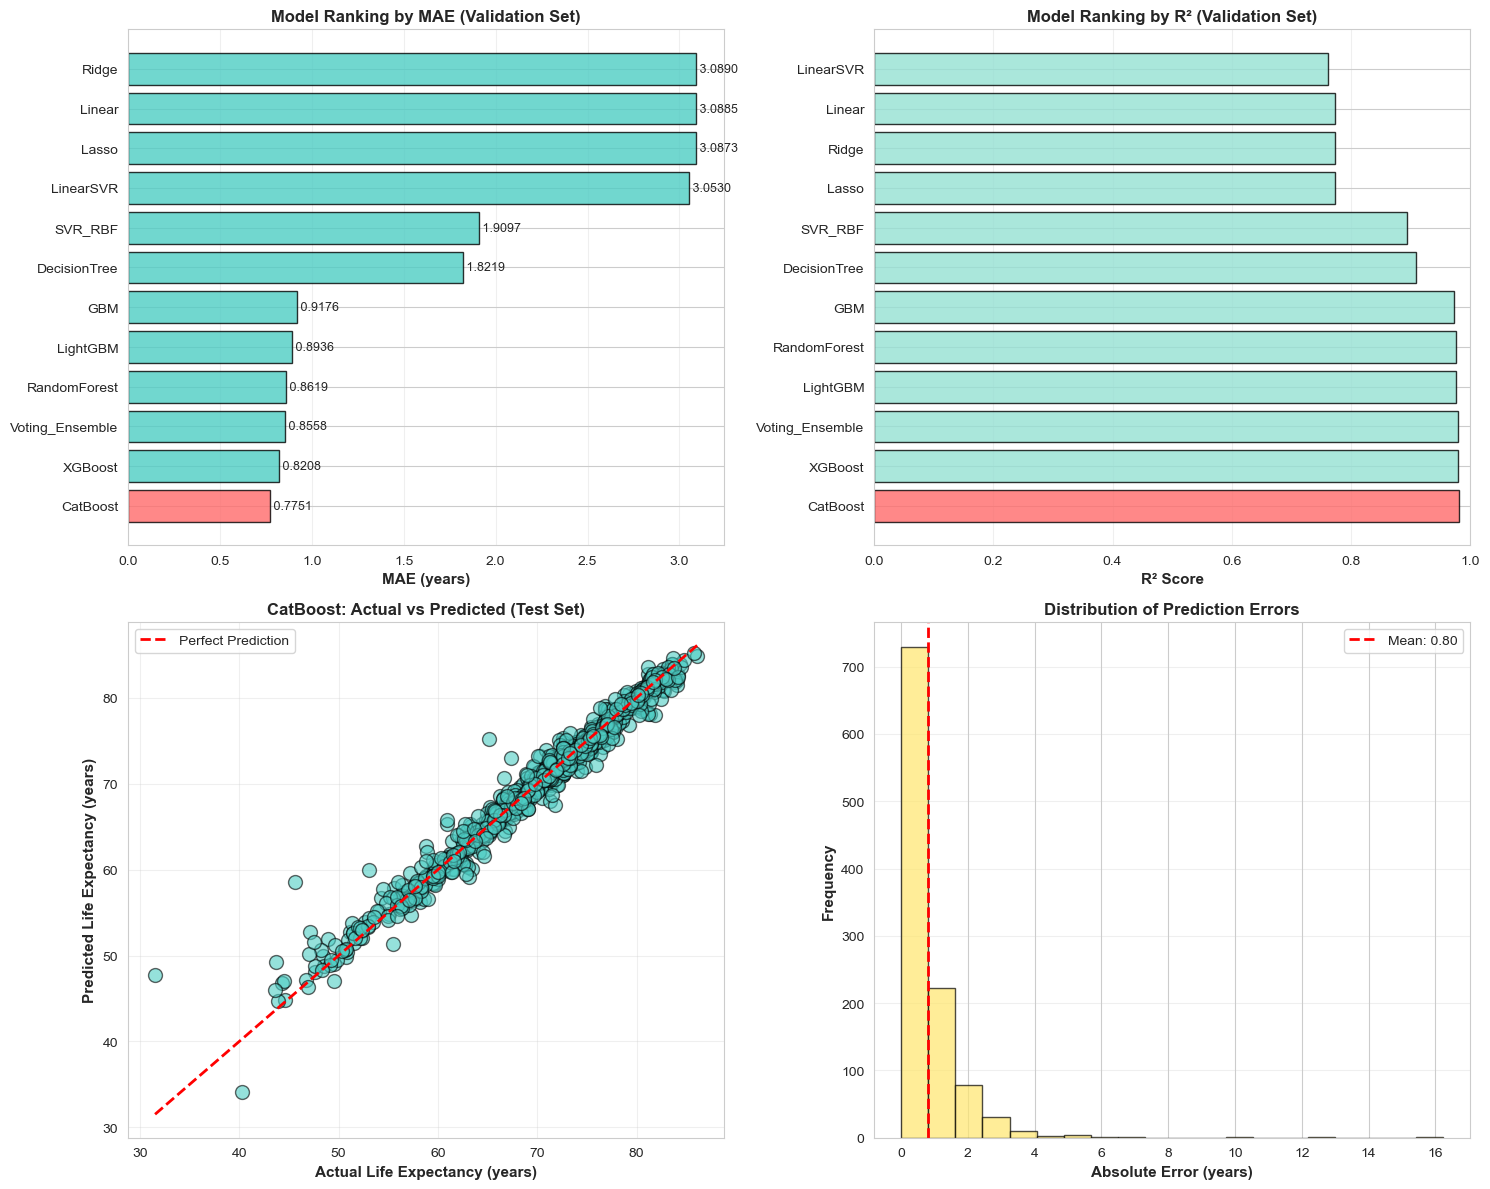

In [49]:
# 1. Biểu đồ so sánh các mô hình
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Subplot 1: Bảng xếp hạng MAE
ax1 = axes[0, 0]
val_df_sorted = val_df_results.sort_values('MAE')
colors = ['#FF6B6B' if i == 0 else '#4ECDC4' for i in range(len(val_df_sorted))]
ax1.barh(val_df_sorted['Model'], val_df_sorted['MAE'], color=colors, edgecolor='black', alpha=0.8)
ax1.set_xlabel('MAE (years)', fontsize=11, fontweight='bold')
ax1.set_title('Model Ranking by MAE (Validation Set)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, (idx, row) in enumerate(val_df_sorted.iterrows()):
    ax1.text(row['MAE'], i, f" {row['MAE']:.4f}", va='center', fontsize=9)

# Subplot 2: R² Scores
ax2 = axes[0, 1]
val_df_sorted_r2 = val_df_results.sort_values('R2', ascending=False)
colors_r2 = ['#FF6B6B' if model == best_model_name else '#95E1D3' for model in val_df_sorted_r2['Model']]
ax2.barh(val_df_sorted_r2['Model'], val_df_sorted_r2['R2'], color=colors_r2, edgecolor='black', alpha=0.8)
ax2.set_xlabel('R² Score', fontsize=11, fontweight='bold')
ax2.set_title('Model Ranking by R² (Validation Set)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_xlim([0, 1])

# Subplot 3: Actual vs Predicted
ax3 = axes[1, 0]
ax3.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', s=100, color='#4ECDC4')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Life Expectancy (years)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Predicted Life Expectancy (years)', fontsize=11, fontweight='bold')
ax3.set_title(f'{best_model_name}: Actual vs Predicted (Test Set)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Subplot 4: Error Distribution
ax4 = axes[1, 1]
ax4.hist(test_results_df['Chênh lệch'], bins=20, edgecolor='black', alpha=0.7, color='#FFE66D')
ax4.axvline(test_results_df['Chênh lệch'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {test_results_df['Chênh lệch'].mean():.2f}")
ax4.set_xlabel('Absolute Error (years)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
os.makedirs('../outputs', exist_ok=True)
plt.savefig('../outputs/model_selection.png', dpi=300, bbox_inches='tight')
print("✓ Biểu đồ đã được lưu tại: ../outputs/model_selection.png")
plt.show()

## Bước 9 - Phân tích Insights

In [55]:
print("\nINSIGHTS VỀ KẾT QUẢ DỰ ĐOÁN")
print("="*100)

print("\n1. TOP 5 QUỐC GIA DỰ ĐOÁN TỐT NHẤT (Lỗi thấp nhất)")
print("-"*100)
best_predictions = test_results_df.nsmallest(5, 'Chênh lệch')
for idx, row in best_predictions.iterrows():
    print(f"  {row['Quốc gia']:<35}: Actual={row['Tuổi thọ thực']:6.2f}, Predicted={row['Tuổi thọ dự đoán']:6.2f}, Error={row['Chênh lệch']:6.4f} ({row['Chênh lệch %']:6.2f}%)")

print("\n2. TOP 5 QUỐC GIA DỰ ĐOÁN TỆ NHẤT (Lỗi cao nhất)")
print("-"*100)
worst_predictions = test_results_df.nlargest(5, 'Chênh lệch')
for idx, row in worst_predictions.iterrows():
    print(f"  {row['Quốc gia']:<35}: Actual={row['Tuổi thọ thực']:6.2f}, Predicted={row['Tuổi thọ dự đoán']:6.2f}, Error={row['Chênh lệch']:6.4f} ({row['Chênh lệch %']:6.2f}%)")

print("\n3. PHÂN TÍCH THEO KHOẢNG TUỔI THỌ")
print("-"*100)
test_results_df['Age_Group'] = pd.cut(test_results_df['Tuổi thọ thực'],
                                      bins=[0, 65, 75, 85, 100],
                                      labels=['Low (< 65)', 'Medium (65-75)', 'High (75-85)', 'Very High (> 85)'])

for group in ['Low (< 65)', 'Medium (65-75)', 'High (75-85)', 'Very High (> 85)']:
    group_data = test_results_df[test_results_df['Age_Group'] == group]
    if len(group_data) > 0:
        print(f"  {group:<20}: n={len(group_data):3d}, MAE={group_data['Chênh lệch'].mean():.4f}, Std={group_data['Chênh lệch'].std():.4f}")

print("\n4. KẾT LUẬN CHUNG")
print("-"*100)
print(f"  • Mô hình tốt nhất: {best_model_name}")
print(f"  • Test MAE = {test_mae:.4f} năm (sai trung bình {test_mae:.2f} năm tuổi thọ)")
print(f"  • Test R² = {test_r2:.4f} (giải thích {test_r2*100:.2f}% phương sai)")

if test_mae < 2.0:
    print(f"  • 🌟 Kết quả TỐT: Model dự đoán rất chính xác")
elif test_mae < 3.5:
    print(f"  • ✓ Kết quả CHẤP NHẬN ĐƯỢC: Model có độ chính xác tốt")
else:
    print(f"  • ⚠️  Kết quả CẦN CẢI THIỆN")


INSIGHTS VỀ KẾT QUẢ DỰ ĐOÁN

1. TOP 5 QUỐC GIA DỰ ĐOÁN TỐT NHẤT (Lỗi thấp nhất)
----------------------------------------------------------------------------------------------------
  Malaysia                           : Actual= 74.03, Predicted= 74.03, Error=0.0003 (  0.00%)
  Uzbekistan                         : Actual= 67.91, Predicted= 67.90, Error=0.0004 (  0.00%)
  French Polynesia                   : Actual= 79.00, Predicted= 79.00, Error=0.0012 (  0.00%)
  Belgium                            : Actual= 78.88, Predicted= 78.88, Error=0.0026 (  0.00%)
  Kazakhstan                         : Actual= 73.50, Predicted= 73.51, Error=0.0027 (  0.00%)

2. TOP 5 QUỐC GIA DỰ ĐOÁN TỆ NHẤT (Lỗi cao nhất)
----------------------------------------------------------------------------------------------------
  Central African Republic           : Actual= 31.53, Predicted= 47.76, Error=16.2332 ( 51.49%)
  Haiti                              : Actual= 45.58, Predicted= 58.56, Error=12.9790 ( 28.48%)


## Bước 10 - Lưu kết quả

In [ ]:
# Lưu các kết quả
os.makedirs('../outputs', exist_ok=True)

# 1. Lưu ranking validation
val_df_results.to_csv('../outputs/model_validation_ranking.csv', index=False)

# 2. Lưu kết quả test chi tiết
test_results_df.to_csv('../outputs/test_predictions_detailed.csv', index=False)

# 3. Lưu so sánh val vs test
comparison_df.to_csv('../outputs/validation_test_comparison.csv', index=False)
print("✓ Validation vs Test comparison saved: ../outputs/validation_test_comparison.csv")

print("\n" + "="*100)
print("TÓM TẮT KẾT QUẢ")
print("="*100)
print(f"Mô hình tốt nhất: {best_model_name}")
print(f"Validation - MAE: {best_mae:.4f}, RMSE: {best_rmse:.4f}, R²: {best_r2:.4f}")
print(f"Test       - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")
print("="*100)

## Kết luận

### Tổng kết:
1. **So sánh tất cả 12 mô hình** trên validation set
2. **Xác định mô hình tốt nhất** dựa trên MAE, RMSE, R² scores
3. **Dự đoán tuổi thọ trên test set** sử dụng mô hình tốt nhất
4. **Phân tích chi tiết kết quả**:
   - Kết quả dự đoán từng quốc gia
   - So sánh validation vs test performance
   - Phân tích lỗi theo nhóm tuổi thọ
   - Vẽ biểu đồ insights
5. **Lưu tất cả kết quả** để phục vụ cho báo cáo